# Distributed optimization algorithms
The goal of this notebook is to work on distributed optimization algorithms, which are the foundation for large scale analytics and machine learning. Specifically, we will focus on the details of stochastic gradient descent (SGD). To do so, we will work on a simple regression problem, where we will apply SGD to minimize a loss function, as defined for the problem at hand. The emphasis of this laboratory is **not** on the machine learning part: even if you've never worked on regression problems, this shouldn't prevent you from being successful in developing the Notebook.

Next, an outline of the steps we will follow in this Notebook:

* Breif introduction to linear regression
* Implementation of serial algorithms: from Gradient Descent, to Stochastic Gradient Descent
* Implementation of distributed algorithms with Apache Spark


### Initialization code

In [8]:
%matplotlib inline
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression

## A simple example: linear regression
Let’s see briefly how to use gradient descent in a simple least squares regression setting. Asssume we have an output variable $y$ which we think depends linearly on the input vector $x$. That is, we have:

$$x = \begin{bmatrix}x_1 \\ x_2 \\ \cdots \\ x_m\end{bmatrix}, y = \begin{bmatrix}y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix}$$

We approximate $y_i$ by:

$$ f_{\theta}(x_i) = \theta_1 + \theta_2 x_i$$

Define the loss function for the simple linear least squares regression as follows:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

Now, let's use scikit learn to create a regression problem. A few notes are in order:

* The call to ```make_regression``` essentially generates samples for a regression problem
* The call to ```stats.linegress``` calculates a linear least-squares regression for two sets of measurements

This means we have a sort of "basline" to experiment with our SGD implementation.

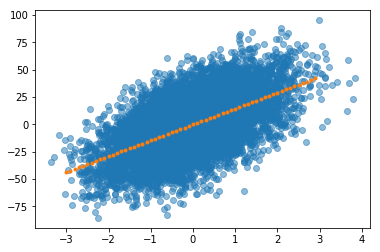

In [2]:
x, y = make_regression(n_samples = 10000, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept,_,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')


## Batch gradient descent
Before delving into SGD, let's take a simpler approach. Assume that we have a vector of paramters $\theta$ and a loss function $J(\theta)$, which we want to minimize. The loss function we defined above has the form:

$$ J(\theta) = \sum_{i=1}^{m} J_i(\theta)$$

where $J_i$ is associated with the i-th observation in our data set, such as the one we generated above. The batch gradient descent algorithm, starts with some initial feasible parameter $\theta$ (which we can either fix or assign randomly) and then repeatedly performs the update:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J(\theta^{(t)}) = \theta^{(t)} - \eta \sum_{i=1}^{m} \nabla_{\theta} J_i(\theta^{(t)}) $$

where $t$ is an iteration index, and $\eta$ is a constant controlling step-size and is called the learning rate. Note that in order to make a **single update**, we need to calculate the gradient **using the entire dataset**. This can be very inefficient for large datasets, and it is the goal of this Notebook to insist on this aspect.

In code, the main loop for batch gradient descent looks like this:

```python
for i in range(n_epochs):
  params_grad = evaluate_gradient(loss_function, data, params)
  params = params - learning_rate * params_grad
```

For a given number of iterations (also called epochs) $n_{e}$ , we first evaluate the gradient vector of the loss function using **ALL** examples in the data set, and then we update the parameters with a given learning rate. Batch gradient descent is guaranteed to converge to the global minimum for convex loss surfaces and to a local minimum for non-convex surfaces.

<div class="alert alert-warning">
<b>NOTE:</b> Who computes the gradient?
<br>
<br>
Given a loss function $J(\theta)$, the gradient with respect to paramters $\theta$ must be derived manually. In other words, given the expression of $J(\theta)$, pencil and paper are required to derive the analytical form of its gradient. Then this expression can be plugged into our code.

Recently, machine learning libraries have adopted the techniques of **automatic differentiation**, which eliminate this tedious and error prone step. Given a loss function $J(\theta)$, such libraries automatically compute the gradient.
</div>


For the linear regression case, let's derive the update step for gradient descent. Recall that we have defined:

$$ J(\theta) = \frac{1}{2} \sum_{i=1}^{m}(f_{\theta}(x_i) - y_i)^2$$

$$f_\theta(x_i) = \theta_1 + \theta_2 x_i$$

So we have that:

$$ \nabla_\theta J(\theta) = \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (\theta_1 + \theta_2 x_i - y_i)^2 $$

If we explicit the partial derivatives of the gradient, we have:

$$\frac{\partial J(\theta)}{\partial \theta_1} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i)$$
$$\frac{\partial J(\theta)}{\partial \theta_2} = \sum_{i=1}^{m} (\theta_1 + \theta_2 x_i - y_i) x_i$$

So now we can explicit the update rules for the two model parameters:

$$ \theta_1^{(t+1)} = \theta_1^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i)$$

$$ \theta_2^{(t+1)} = \theta_2^{(t)} - \eta \sum_{i=1}^{m}  (\theta_1^{(t)} + \theta_2^{(t)} x_i - y_i) x_i$$


### Using matrix notation
Now, before writing some code, let's see how can we simplify the above expressions using matrices. Note that this is not only useful for working on a more compact notation, but it helps reason about efficient computations using libraries such as numpy, which we will use extensively.

We firstly expressed our prediction as: $f_\theta (x_i) = \theta_1 + \theta_2 x_i$. Let's introduce a surrogate dimension for our input set $x$, such that:

$$x = 
\begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix}
$$

where we define, with a small abuse of notation, $x_i = \begin{bmatrix} 1 & x_{i}\end{bmatrix}$. Also, let's define vector $\theta = \begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix}$. 

Then, we can rewrite $f_\theta(x_i) = x_i \theta = \begin{bmatrix} 1 & x_{i}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} = \theta_1 + \theta_2 x_i$.

Let's use this notation to rewrite our gradients in matrix form.


$\nabla_\theta J(\theta) =  \frac{1}{2} \sum_{i=1}^{m} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{m} (x_i \theta - y_i) x_i^T =$


$= x^T (x \theta - y) =$


$= \begin{bmatrix} 1 & 1 & \cdots & 1 \\ x_1 & x_2 & \cdots & x_m \end{bmatrix} 
\Bigg( \begin{bmatrix} 1& x_{1} \\ 1 & x_{2} \\ \cdots & \cdots \\ 1 & x_{m}\end{bmatrix} 
\begin{bmatrix} \theta_1 \\ \theta_2\end{bmatrix} - 
\begin{bmatrix} y_1 \\ y_2 \\ \cdots \\ y_m\end{bmatrix} \Bigg)$

### Numpy arrays
With the work we did above, we can now cast everything into numpy arrays, which are efficient, and for which an efficient implementation of vector and matrix operations exists. Specifically, above we used the traditional matrix notation, where we manipulate column vectors. Hence, we express matrix operations (namely matrix products) using the traditional "row-by-column" approach.

In numpy, we avoid this formalism by using dot product operations. So, given two column vectors:
$$a= \begin{bmatrix} a_1 \\ a_2 \\ \cdots \\ a_{m}\end{bmatrix} b= \begin{bmatrix} b_1 \\ b_2 \\ \cdots \\ b_{m}\end{bmatrix}$$
we have that $a b^T = a \cdot b = a_1 b_1 + a_2 b_2 + \cdots + a_m b_m$, where $\cdot$ is the symbol we use for dot product.

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

In [64]:
#GRADIENT DESCENT#

def gradient_descent(x,y, q1,q2, learning_rate, max_iters,marg_improv):
    x_ones = np.array([np.zeros(x.size)+1,x]) #array of all 1s
    theta_array = np.array([q1,q2])
    
    history_gradients=[]
    history_loss=[]
    history_thetas=[]
    
    previous_loss = 1000000 #initial start value is high

    for i in range(max_iters):
        
        #calculate theta, loss and grad for this iteration
        tmp_theta = x_ones.T.dot(theta_array)
        tmp_loss = 0.5*(tmp_theta-y).dot((tmp_theta-y).T)/x.size
        tmp_grad = x_ones.dot(tmp_theta-y)/x.size
        
        #save them to history lists
        
        history_thetas.append(tmp_grad)
        history_loss.append(tmp_loss)
        history_gradients.append(tmp_theta)
        
        if (abs(tmp_loss-previous_loss) < marg_improv):
            break #not enough improvment anymore so break
        
        
        #set the previous loss
        previous_loss = tmp_loss
        
        #update the change of the thetas for this iteration
        theta_array = theta_array - learning_rate * tmp_grad
        
    #return the iteration count, final theta and the history of other 3
    return i, theta_array, np.array(history_thetas), np.array(history_loss), np.array(history_gradients) 

Iterations made before marginal improvement break: 57
Scikitlearn values:
('Intercept: ', -0.10682356416090799)
('Slope: ', 14.515169479593917)

Gradient descent values:
('Intercept: ', -0.0960551257532899)
('Slope: ', 14.488774762517526)


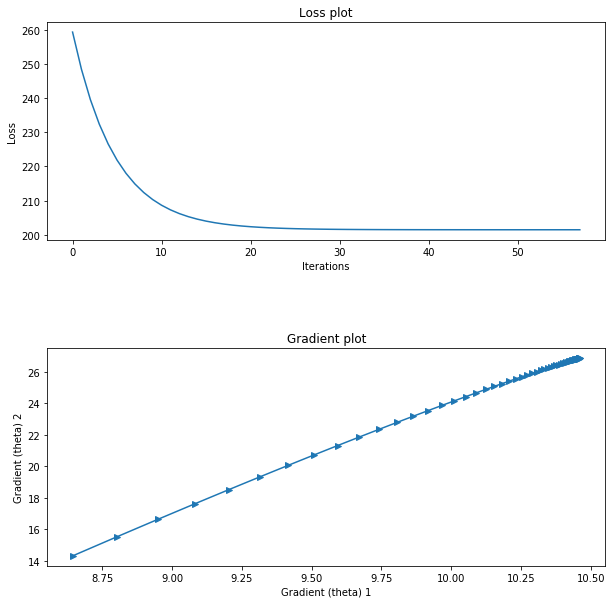

In [68]:
itr, gd_theta, gd_thetas, gd_loss_values, gd_gradients = gradient_descent(x,y,5,5,0.1,100,0.0001)

print "Iterations made before marginal improvement break:", itr

print("Scikitlearn values:")
print("Intercept: ", intercept)
print("Slope: ", slope)
print("\nGradient descent values:")
print("Intercept: ", gd_theta[0])
print("Slope: ", gd_theta[1])


fig, arr = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
fig.set_size_inches(10, 10)

arr[0].plot(np.arange(len(gd_loss_values)), gd_loss_values)
arr[0].set_xlabel("Iterations")
arr[0].set_ylabel("Loss")
arr[0].set_title("Loss plot")
arr[1].plot(gd_gradients[:,0], gd_gradients[:,1], '->')
arr[1].set_xlabel("Gradient (theta) 1")
arr[1].set_ylabel("Gradient (theta) 2")
arr[1].set_title("Gradient plot")
plt.show()


<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Plot the regression line, along with the training data, given the coefficients $\theta$ that you have obtained with Gradient Descent.
</div>

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Plot a 3D surface representing: on the x,y axes the parameter values, on the z axis the loss value. Additionally, plot the trajectory of the loss function on the 3D surface, using the history you collected in the gradient_descent function you designed.

Finally, plot a contour projection of the 3D surface, along with the corresponding projection of the trajectory followed by your Gradient Descent algorithm.
</div>

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Plot the path the gradient takes from its initial to its final position.

This is a two dimensional plot (because our parameter vector has size 2), with a point for each gradient value, and a line connecting the points.
</div>

## Stochastic Gradient Descent

The gradient descent algorithm makes intuitive sense as it always proceeds in the direction of steepest descent (the gradient of $J$) and guarantees that we find a local minimum (global under certain assumptions on $J$). When we have very large data sets, however, computing $\nabla_\theta J(\theta)$ can be computationally challenging: as noted above, we must process every data point before making a single step (hence the name "batch"). 

An alternative approach to alleviate such computational costs is the Stochastic Gradient Descent method: essentially, the idea is to update the parameters $\theta$ sequentially (one data point at the time), with every observation $x_i, y_i$. Following the same notation we used for Gradient Descent, the following expression defines how to update parameters, while processing one data point at the time:

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} J_i(\theta^{(t)}) $$


The stochastic gradient approach allows us to start making progress on the minimization problem one step at the time. It is computationally cheaper, but it results in a larger variance of the loss function in comparison with batch gradient descent.

Generally, the stochastic gradient descent method will get close to the optimal $\theta$ much faster than the batch method, but will never fully converge to the local (or global) minimum. Thus the stochastic gradient descent method is useful when we are satisfied with an **approximation** for the solution to our optimization problem. 

A full recipe for stochastic gradient descent follows:

```python 
for i in range(n_epochs):
  np.random.shuffle(data)
  for example in data:
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
```

The reshuffling of the data is done to avoid a bias in the optimization algorithm by providing the data examples in a particular order.

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Implement your own version of Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>

    
The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

## Mini-batch Stochastic Gradient Descent

Mini-batch gradient descent is a trade-off between stochastic gradient descent and batch gradient descent.  In mini-batch gradient descent, the cost function (and therefore gradient) is averaged over a small number of samples, which is what we call the mini-batch, and that we denote by $mb$.  This is opposed to the SGD batch size of 1 sample, and the BGD size of all the training samples. 

Let's use the notation we introduced above to rewrite the gradients in matrix form for the mini-batch variant:

$\nabla_\theta J(\theta) =  \frac{1}{2 mb} \sum_{i=1}^{mb} \nabla_\theta (x_i \theta - y_i)^2$


$= \sum_{i=1}^{mb} (x_i \theta - y_i) x_i^T =$


$= x_{mb}^T (x_{mb} \theta - y_{mb})$


What’s the benefit of doing it this way?  First, it smooths out some of the noise in SGD, but not all of it, thereby still allowing the “kick” out of local minimums of the cost function.  Second, the mini-batch size is still small, thereby keeping the performance benefits of SGD.





<div class="alert alert-block alert-info"> 
<strong>Question 6.</strong> Implement your own version of Mini-batch Stochastic Gradient Descent, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to extract mini-batches from the training data.
    <li> Define a function to perform gradient descent. The function should accept as inputs: the training data $x$ and $y$, the initial guess for the parameters ($\theta_1$ and $\theta_2$), the learning rate. Additional arguments include the definition of the maximum number of iterations before the algorithm stops, and a second stop condition on the marginal improvment on the loss.</li>
    <li> Keep track of the values of the loss, for each iteration.</li>
    <li> Keep track of the gradient values, for each iteration.</li>
</ul>

<br>
Once the ```gradient_descent``` function is defined, you can generate input data according to the cell above, that use scikitlearn.
<br>


The output of your cell should contain the following information:
<ul>
    <li> The values of the paramters obtained through Gradient Descent optimization </li>
    <li> The values of the paramters obtained with the above cell, using scikitlearn </li>
    <li> A plot of the loss versus iterations </li>
    <li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Compare the loss rate of the three approachs, Gradient Descent, Stochastic Gradient Descent, Mini-batch Stochastic Gradient Descent, by plotting in the same figure, the loss rate as a function of iterations. 


Comment the behavior of the three algorithms.
</div>

***

## Distributed Mini-Batch Stochastic Gradient Descent
We're now ready to study the problem of distributed, mini-batch stochastic gradient descent. Clearly, so far we've worked with very small datasets: as a consequence it is hard to appreciate the computational bottleneck of serial implementations. But before we delve into an experimental setting, and try to spice things up with larger datasets, let's focus on the problem per se.

The problem statement is as follows: we need to design a distributed version of the algorithm we examined above, that is the Mini-Batch Stochastic Gradient Descent. In the interest of time, and also because in this laboratory we want to work with Apache Spark, we will look at **synchronous** distributed algorithms. Don'y worry, things will be much more clear in the next section!

As a complement to this introduction, here's a list of references that are useful for this Notebook, and more generally that constitute the base for those of you interested in distributed optimization algorithms, an important element of large-scale machine learning.

The first reference is a research paper that was published in 2010, in a very important conference called NIPS. I suggest to have a look at section 1 only, unless you want to pursue a PhD, in which case I strongly suggest to contact me, I'm always looking for bright students to work with!

The following references are a collection of pointers to real code, which essentially implement the ideas presented in the research paper we mentioned. Beware, this is Scala code, whereas we use Python. Nevertheless, you'll find a lot of inspiring hints for your own code. Again, I suggest to start simple, and avoid the regularization part. On another note, it is interesting to look at code that is meant to be integrated as a contribution to a popular open source software, such as Apache Spark, and in particular MLLib. This is in stark contrast to the "coding style" we adopt in this Notebook, which is to be considered experimental, and far from being compliant with any principled approach to software engineering.


#### References
* Parallelized Stochastic Gradient Descent: http://martin.zinkevich.org/publications/nips2010.pdf
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/ParallelizedSGD.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/main/scala/org/apache/spark/mllib/optimization/SGDUpdater.scala
* https://github.com/yu-iskw/spark-parallelized-sgd/blob/master/src/test/scala/org/apache/spark/mllib/optimization/ParallelizedSGDSuite.scala

### Some useful hints to design your distibuted algorithm

In this Notebook we will use Apache Spark, which is simply a fantastic tool! As we've learned in class (and this is actually true for Hadoop MapReduce as well as for any other distributed computing framework embracing the Bulk Synchrnous Parallel (BSP) programming model), Apache Spark features a synchronization barrier that really helps in dealing with distributed computations. To simplify the discussion (a much more profound treatment of the subject can be found in this nice book http://www.parallel-algorithms-book.com/), in Apache Spark workers operate synchronously, in that the result of their computation, when aggregated or distributed, is processed only when **all** workers are done. So on the one hand, this simplifies the programming model, while on the other hand, this might introduce "stragglers", that is slow workers that penalize the performance of your distributed algorithm.

So what are the basic steps you should follow to design and implement your distributed algorithm?

#### Algorithm pseudo-code
In what follows, we outline the algorithm pseudo-code, to help you think about your algorithm implementation.

```python
for i in range(iterations)
  
  # Randomly partition the input, giving T examples to each machine.
  mini_batches = sample(input_data)

  # Initialize random paramters
  params = initialize
  
  # This part executes in parallel, on each of the k worker machines
  # This is essentially the same code as for the serial implementation
  # Indeed, we're working on an embarassingly parallel formulation
  for data in mini_batch: 
    params_grad = evaluate_gradient(loss_function, example, params)
    params = params - learning_rate * params_grad
    
  # Here we aggregate from all machines, and compute the update for iteration i
  # The update is simply the average of all updates coming from each of the k worker machines
  Aggregate from all computers params = average(params_k)
```

#### Input data and parameters
As for the input data, we want to use the same procedure we used from the beginning of the Notebook: we use scikit learn to generate our $x$ and $y$.
Then, you have to find ways to **partition** this data across the machines you have in your cluster. The method ```sc.parallelize``` comes handy here.

Once you have a parallel collection, that takes the form of an ```RDD```, you'll have to ```sample``` from it, to create random mini batches, each of which will be used **independently** by each worker machine to process its own data. Be careful that here we want to **keep the data partitioning** of our original data. You should be wise enough to lookup for the PySpark API to get the details of the methods we suggested here: ```sample``` and ```mapPartitions```.

Last but not least, we have to take care about the parameters! The initial parameter values, as well as any updates to them, must be shipped to all worker machines. There are various ways to do this, exploiting the great flexibility of Apache Spark. This data could be serialized and shipped along with the code each task should execute. However, a much more efficient method to do this is to exploit what we have learned in class, namely ```broadcast variables```. You might argue that for our simple Notebook, since the parameter vector is of size 2, this is not a big deal. However, for different scenarios, like big models, having an efficient primitive to ship a lot of data to workers is a big plus: remember that broadcast variables are sent to workers using a protocol very similar to BitTorrent, a famous peer-to-peer content distribution system.

#### Driver vs. workers

Now, to clarify even further what we expect from our Apache Spark program, here's some additional information about the roles of each component invovled in the execution of the pseudo-code outlined above.


Essentially, the ```driver``` machine (the one where the ```SparkContext``` is created), is the one responsible for executing the "serial" part of the algorithm: prepare and dispatch data, and wait for the contributions coming from all machines.


Instead, the ```worker``` machines receive their task to execute, proceed independently (some faster than others), and send their updates to the driver. The driver will **wait for all updates from workers** before proceeding with the final aggregation.

#### Additional hints

As you might have heard in class, Apache Spark has a lot of surprises. On of such cool methods allow you to define the way data is aggregated. Indeed, you surely realized that (in the old Hadoop MapReduce jargon) we're talking about a "map only job": workers "map" on their minibatch, computing partial gradient updates, then send everything (more or less at the same time) to the driver machine. At the scale of this Notebook, this is rather harmless. Instead, at larger scale, this could create "congestion" in the driver: a nice solution to this would be to have the possibility to aggregate data along a tree-structure, which would involve worker machines as well as the driver.


One final note. In case you wonder how to produce an ```iterable``` in python with a singleton in it, just ```return (variable, )```.

<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Implement your own version of Mini-Batch, Stochastic Gradient Descent, as a **distributed** algorithm.

    
The output of your cell should contain the following information:
<ul>
<li> The values of the paramters obtained through Gradient Descent optimization </li>
<li> The values of the paramters obtained with the above cell, using scikitlearn </li>
<li> A plot of the loss versus iterations </li>
<li> A plot of the path the gradient takes from its initial to its final position </li>
</ul>
</div>

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Inspecting your input data, and its partitioning.
<br>

Answer the following questions:
<ul>
    <li>What is the best way to partition your data, given your cluster configuration? How many partitions did you chose</li>
    <li>Given the number of partitions from the first point, how many RDD blocks is your data broken into?</li>
    <li>What would be different if you were to concieve the same algorithm digesting input data stored as a CSV file on HDFS? Argue about how to "ship" data to worker machines, partitions, blocks, etc...</li>
</ul>
</div>


**```[HINT]```** The questions above are best answered by looking at the Spark Master Web UI.

<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Finding bottlenecks.

<ul>
    <li>What is the bottleneck in the current implementation of your algorithm?</li>
    <li>Can you nail down exactly which method is causing this bottleneck?</li>
    <li>Can you suggest ways to mitigate or eliminate the bottleneck?</li>
</ul>
</div>

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison of serial vs. distributed algorithms.
</div>

Given all the implementation effort you did so far, this question is about an experimental study on scalability. Given input data sizes in the range $[10^2, 10^3, 10^4, 10^5]$, collect the run-time and the loss rate at convergence for all variants of the serial algorithms and for the distributed one. Produce a plot with 2 y-axis, one for the run-time, one for the loss rate, and one x-axis with the input data size.

Discuss your results.
